420-A52-SF - Algorithmes d'apprentissage supervisé - Hiver 2020 - Spécialisation technique en Intelligence Artificielle<br/>
MIT License - Copyright (c) 2020 Mikaël Swawola
<br/>
![Travaux Pratiques - Évaluation des modèles de classification](static/14-tp-banner.png)
<br/>
**Objectif:** cette séance de travaux pratiques a pour objectif la mise en oeuvre des différentes techniques d'évaluation des modèles de classifications sur des données débalancées

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### 1 - Simulation de données

In [2]:
!pip install imblearn

In [3]:
from sklearn.datasets import make_moons
from imblearn.datasets import make_imbalance

In [4]:
N = 10000
ratio_debalancement = 0.01

X_raw, y_raw = make_moons(n_samples=10*N, shuffle=True, noise=0.3, random_state=2020)
X, y =  make_imbalance(X_raw, y_raw, sampling_strategy={0: int(N*(1-ratio_debalancement)), 1: int(N*(ratio_debalancement))})

In [5]:
import matplotlib.pyplot as plt

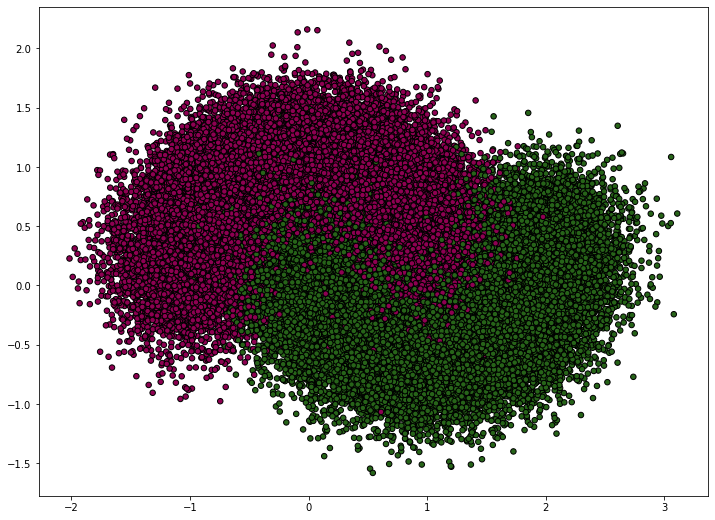

In [6]:
fig = plt.figure(1, figsize=(12, 9))
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y_raw, cmap='PiYG', edgecolor='k', s=30)
plt.show()

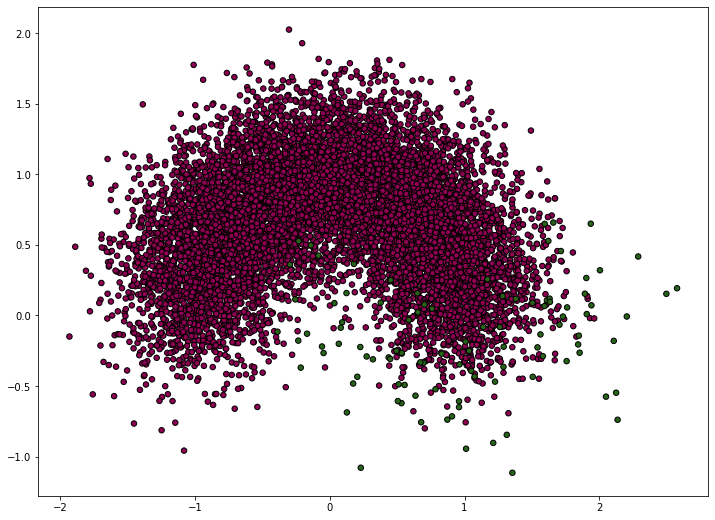

In [7]:
fig = plt.figure(1, figsize=(12, 9))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='PiYG', edgecolor='k', s=30)
plt.show()

### 2 - Préparation de données

In [8]:
from sklearn.model_selection import train_test_split

Train: 40%

Validation 30%

Test: 30%

In [9]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.30, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.42857, stratify=y_)

In [10]:
import numpy as np
print(f'Raw, classe négative {len(y) - np.sum(y)}') 
print(f'Train, classe négative {len(y_train) - np.sum(y_train)}') 
print(f'Val, classe négative {len(y_val) - np.sum(y_val)}')
print(f'Test, classe négative {len(y_test) - np.sum(y_test)}')

Raw, classe négative 9900
Train, classe négative 3960
Val, classe négative 2970
Test, classe négative 2970


### 3 - Modèle de référence (baseline)

In [11]:
from sklearn.dummy import DummyClassifier

In [12]:
baseline_clf = DummyClassifier(strategy='most_frequent') 
baseline_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
y_pred_train = baseline_clf.predict(X_train)
acc_baseline = accuracy_score(y_pred_train, y_train)
print(f'Performance du modèle de référence (dummy): {100*acc_baseline}%')

Performance du modèle de référence (dummy): 99.0%


### 4 - Entraînement d'un classificateur (régression logistique)

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [16]:
poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(X)

In [17]:
logreg = LogisticRegression(C=0.1)

In [18]:
logreg.fit(X_poly, y)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

CC = np.c_[xx.ravel(), yy.ravel()]
Z = logreg.predict_proba(poly.fit_transform(CC))[:,1]

([], <a list of 0 Text yticklabel objects>)

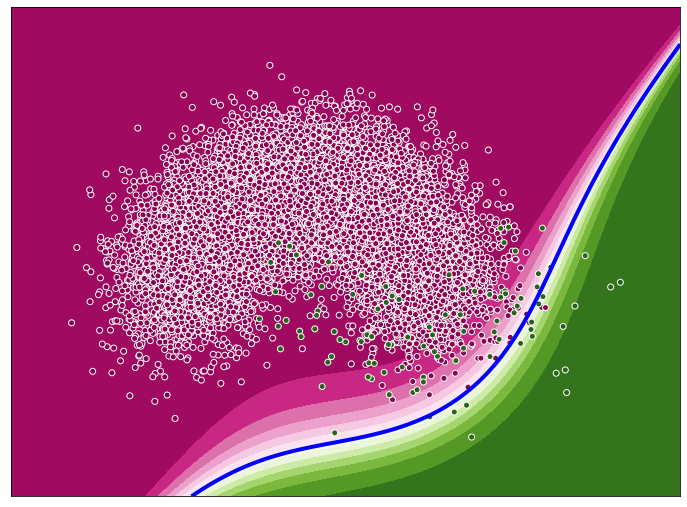

In [19]:
Z = Z.reshape(xx.shape)
fig = plt.figure(2, figsize=(12, 9))

plt.contourf(xx, yy, Z, cmap="PiYG", levels=15)
plt.contour(xx, yy, Z, [0.5], colors=["b"], linewidths=[4])

plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='w', cmap='PiYG', linewidth=1)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

### 5 - Matrice de confusion sur l'ensemble de validation

In [20]:
from sklearn.metrics import confusion_matrix
from helpers import plot_confusion_matrix

In [21]:
threshold = 0.5

y_val_pred_proba = logreg.predict_proba(poly.fit_transform(X_val))[:,1]
y_val_pred_label = y_val_pred_proba > threshold

Confusion matrix, without normalization


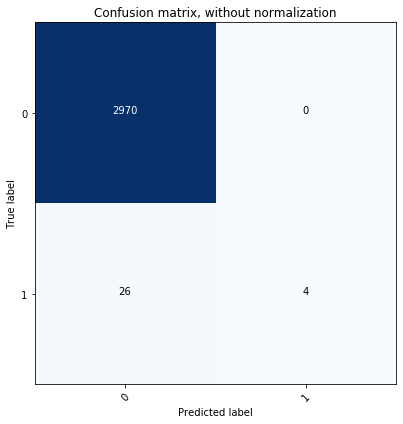

In [22]:
fig = plt.figure(3, figsize=(6, 6))

cnf_matrix = confusion_matrix(y_val, y_val_pred_label)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['0','1'], title='Confusion matrix, without normalization')

#### Calcul de la précision sur l'ensemble de validation

In [23]:
accuracy_score(y_val, y_val_pred_label)

0.9913333333333333

### 6 - Courbe ROC et l'AUC

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

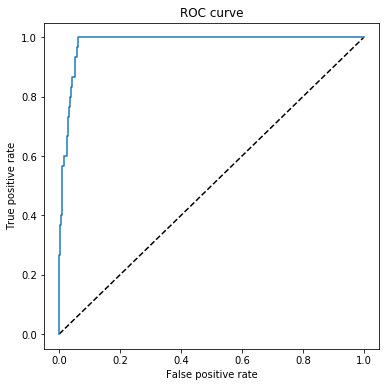

In [25]:
fpr_rf, tpr_rf, thresholds = roc_curve(y_val, y_val_pred_proba)

fig = plt.figure(4, figsize=(6, 6))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#### Calcul de la précision sur l'ensemble de validation

In [26]:
roc_auc_score(y_val, y_val_pred_proba)

0.9818069584736251

#### Sélection de la meilleur valeur du seuil

In [27]:
selected_threshold = thresholds[np.argmax(-fpr_rf + tpr_rf)]
selected_threshold

0.023197770849248796

([], <a list of 0 Text yticklabel objects>)

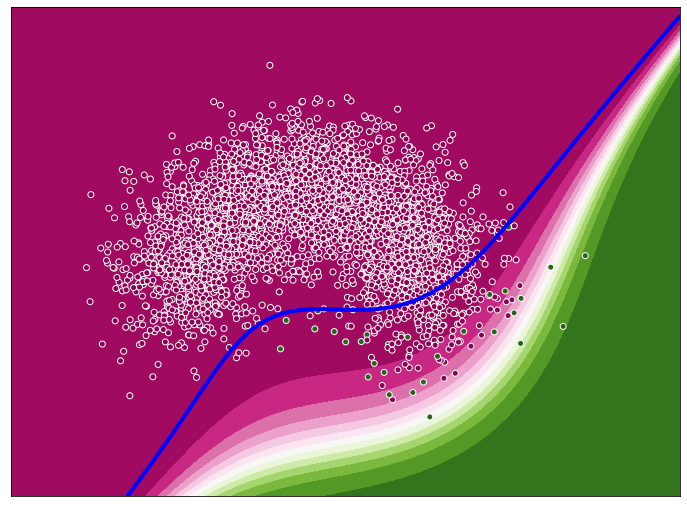

In [31]:
fig = plt.figure(5, figsize=(12, 9))

plt.contourf(xx, yy, Z, cmap="PiYG", levels=15)
plt.contour(xx, yy, Z, [selected_threshold], colors=["b"], linewidths=[4])

plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, edgecolors='w', cmap='PiYG', linewidth=1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

Confusion matrix, without normalization


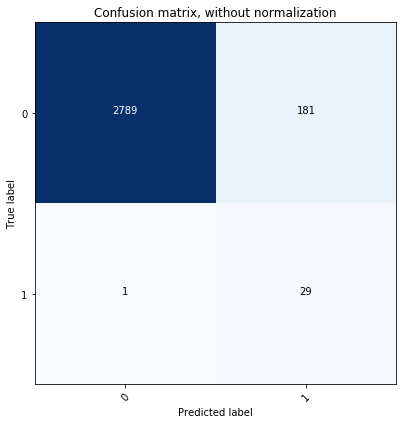

In [29]:
y_val_pred_label = y_val_pred_proba > selected_threshold

fig = plt.figure(6, figsize=(6, 6))
cnf_matrix = confusion_matrix(y_val, y_val_pred_label)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')

### 7 -  Calculer la courbe de précision/rappel

In [32]:
from sklearn.metrics import precision_recall_curve

In [33]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

Text(0.5, 1.0, 'Precision-Recall curve')

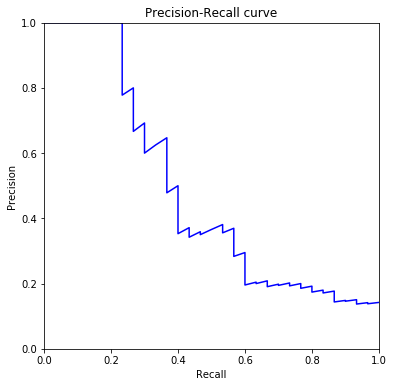

In [34]:
fig = plt.figure(7, figsize=(6, 6))

plt.plot(recall, precision, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')

### 8 - Évaluer le F-score pour différents seuils

In [35]:
from sklearn.metrics import fbeta_score

In [40]:
beta = 4

M = 1000
thresholds = np.linspace(-0.1, 1.1, M)
score = np.zeros(shape=(M,))
for i in range(0,len(thresholds)):
    y_pred_ = (y_val_pred_proba > thresholds[i])*1.0
    score[i] = fbeta_score(y_val, y_pred_, beta)

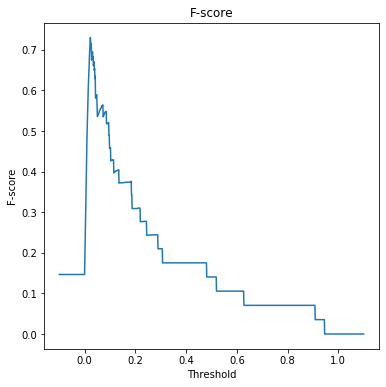

In [41]:
fig = plt.figure(8, figsize=(6, 6))

plt.plot(thresholds, score)
plt.xlabel('Threshold')
plt.ylabel('F-score')
plt.title('F-score')
plt.show()

In [42]:
selected_threshold = thresholds[np.argmax(score)]
selected_threshold

0.02252252252252253

Confusion matrix, without normalization


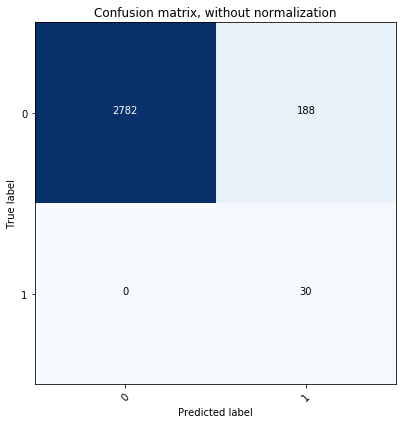

In [43]:
y_val_pred_label = y_val_pred_proba > selected_threshold

fig = plt.figure(6, figsize=(6, 6))
cnf_matrix = confusion_matrix(y_val, y_val_pred_label)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')

### 9 - Calcul de la métrique d'entropie croisée

In [44]:
from sklearn.metrics import log_loss

In [45]:
log_loss(y_val, y_val_pred_proba)

0.029975633880748295

### 10 - Calcul de la métrique d'utilité

In [46]:
FP_loss = -0
FN_loss = -0
TP_reward = 1
TN_reward = 1
utility = lambda cnf_matrix: cnf_matrix[1,1]*TP_reward + cnf_matrix[0,0]*TN_reward + cnf_matrix[1,0]*FN_loss + cnf_matrix[0,1]*FP_loss

In [47]:
M = 100
thresholds = np.linspace(-0.1, 1.1, M)
score = np.zeros(shape=(M,))
for i in range(0,len(thresholds)):
    y_pred_ = (y_val_pred_label > thresholds[i])*1.0
    cnf_matrix = confusion_matrix(y_val, y_pred_)
    score[i] = utility(cnf_matrix)

Text(0.5, 1.0, 'Utility-based cost')

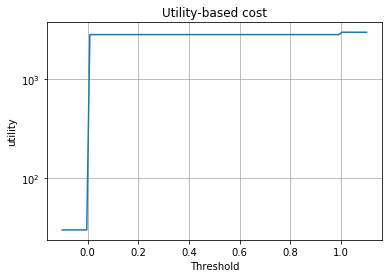

In [48]:
f = plt.figure(4541)
plt.grid(True)
plt.ion()
plt.yscale('symlog')
plt.plot(thresholds, score)
plt.xlabel('Threshold')
plt.ylabel('utility')
plt.title('Utility-based cost')

In [49]:
thresholds[np.argmax(score)]

1.0030303030303032